# Домашнее задание по обработке текстов

## Предсказание цены акции по экономическим новостям

Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from pymystem3 import Mystem
from scipy.stats import pearsonr
from sklearn.metrics import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
import pymorphy2
from gensim.models import LsiModel
from gensim import corpora
from gensim.corpora import Dictionary
%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv('texts.csv', date_parser='date')
df.head()

,date,text
0,09.11.2017,Компания рассчитывает на решение по газовому с...
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,01.11.2017,Новая редакция американских санкций ставит по...
3,30.10.2017,"Как стало известно “Ъ”, известный на рынке ри..."
4,23.10.2017,"НОВАТЭК, который через пять лет собирается за..."


In [3]:
df.shape

(1203, 2)

In [4]:
pr_all = pd.read_csv('gazprom_prices.csv', sep=';')
pr_all.head(5)

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,08.12.2017,"133,43000","132,60000","133,90000","132,00000",16037970
1,07.12.2017,"133,70000","133,02000","133,87000","132,81000",18198430
2,06.12.2017,"133,33000","134,00000","134,29000","132,91000",14641730
3,05.12.2017,"133,48000","133,65000","133,99000","132,78000",12684800
4,04.12.2017,"133,01000","133,77000","134,00000","131,93000",17818980


In [5]:
pr_all.shape

(1988, 6)

In [6]:
pr_all.rename(index=str, columns={"Date": "date", "Open": "open"}, inplace=True)

In [7]:
pr_all.head(3)

,date,open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,08.12.2017,"133,43000","132,60000","133,90000","132,00000",16037970
1,07.12.2017,"133,70000","133,02000","133,87000","132,81000",18198430
2,06.12.2017,"133,33000","134,00000","134,29000","132,91000",14641730


### Часть 1. Вводная

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* О каких санкциях пишут в статьях?

### Есть ли корреляция между средней длинной текста за день и ценой закрытия?

In [8]:
df['len'] = df['text'].apply(len)

In [9]:
df.head(3)

,date,text,len
0,09.11.2017,Компания рассчитывает на решение по газовому с...,419
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова...",624
2,01.11.2017,Новая редакция американских санкций ставит по...,834


In [10]:
#Проверим сколько текстов приходится на одну дату. Если количество уникальных дат = количеству строк,
#тогда можно сделать вывод, что на одну дату приходится один текст
df.date.unique().shape[0], df.shape[0]

(1203, 1203)

In [11]:
pr_all[['open', 'ClosingPrice', 'DailyHigh', 'DailyLow']] = \
pr_all[['open', 'ClosingPrice', 'DailyHigh', 'DailyLow']].apply(lambda x: x.str.replace(',','.'))

pr_all[['open', 'ClosingPrice', 'DailyHigh', 'DailyLow']] = \
pr_all[['open', 'ClosingPrice', 'DailyHigh', 'DailyLow']].apply(pd.to_numeric)

In [12]:
result = pd.merge(df, pr_all, how='inner', on='date')

In [13]:
result.head(3)

,date,text,len,open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,09.11.2017,Компания рассчитывает на решение по газовому с...,419,132.31,131.5,132.82,131.14,33869650
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова...",624,132.00,132.3,133.94,131.58,39381960
2,01.11.2017,Новая редакция американских санкций ставит по...,834,126.40,126.5,126.89,125.97,18232550


In [14]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1159 entries, 0 to 1158
Data columns (total 8 columns):
date            1159 non-null object
text            1159 non-null object
len             1159 non-null int64
open            1145 non-null float64
ClosingPrice    1159 non-null float64
DailyHigh       1158 non-null float64
DailyLow        1157 non-null float64
VolumePcs       1159 non-null int64
dtypes: float64(4), int64(2), object(2)
memory usage: 81.5+ KB


In [15]:
result.dropna(inplace=True)

In [16]:
result['profit'] = result['ClosingPrice'] - result['open'] 

In [17]:
result.head(3)

,date,text,len,open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,profit
0,09.11.2017,Компания рассчитывает на решение по газовому с...,419,132.31,131.5,132.82,131.14,33869650,-0.81
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова...",624,132.00,132.3,133.94,131.58,39381960,0.30
2,01.11.2017,Новая редакция американских санкций ставит по...,834,126.40,126.5,126.89,125.97,18232550,0.10


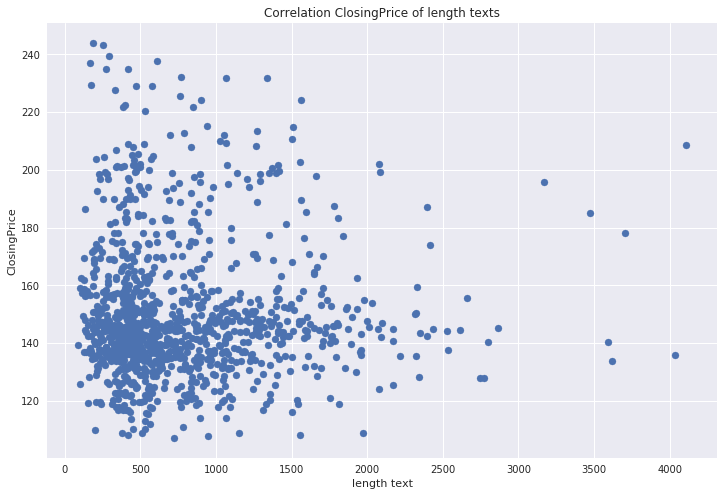

In [18]:
plt.figure(figsize=(12, 8))
plt.scatter(result.len, result.ClosingPrice)
plt.title('Correlation ClosingPrice of length texts')
plt.xlabel('length text')
plt.ylabel('ClosingPrice')
plt.show();

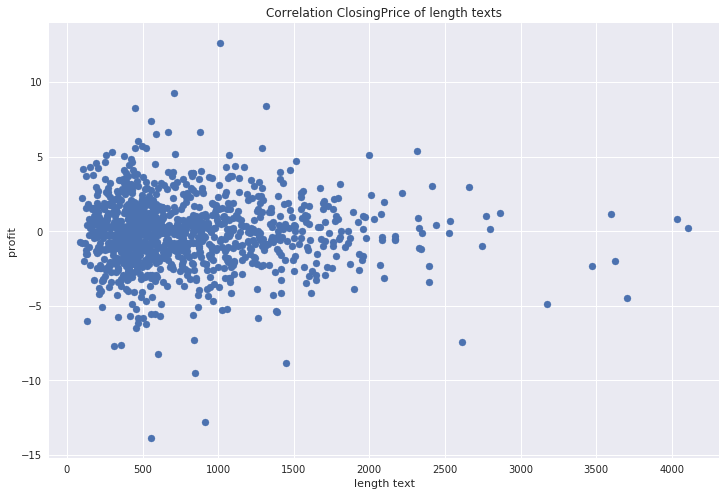

In [19]:
plt.figure(figsize=(12, 8))
plt.scatter(result.len, result.profit)
plt.title('Correlation ClosingPrice of length texts')
plt.xlabel('length text')
plt.ylabel('profit')
plt.show();

In [20]:
pearsonr(result.len, result.ClosingPrice)

(0.01237395542391097, 0.67575212736499313)

In [21]:
pearsonr(result.len, result.profit)

(-0.022664606286062237, 0.44356786162944228)

##### Ответ: корреляции нет.
В принципе было видно и по графику, что корреляции нет между длинной текста и ценой закрытия, но для уверенности мы рассчитали его с помощью функции __personr__ и получили значение -0.0226, которое близко к 0.


### Обработаем текст:
* Приведем все слова к нижнему регистру - str.lower
* Оставим только слова - word_only
* Удалим стоп-слова - remove_stopwords
* Проведем лемматизацию - lemmatize

In [22]:
regex = re.compile("[А-Яа-я-]+")
mystopwords = stopwords.words('russian')
mystopwords.extend(['-', 'руб', 'млрд', 'г', 'год'])
m = Mystem()

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
    
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [23]:
result.text = result.text.str.lower()
result.text = result.text.apply(words_only)
result.text = result.text.apply(remove_stopwords)   
result.text = result.text.apply(lemmatize)

In [24]:
result.head(3)

,date,text,len,open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,profit
0,09.11.2017,компания рассчитывать решение газовый спор укр...,419,132.31,131.5,132.82,131.14,33869650,-0.81
1,08.11.2017,предполагать ъ газпром воспользоваться жалоба ...,624,132.00,132.3,133.94,131.58,39381960,0.30
2,01.11.2017,новый редакция американский санкция ставить уг...,834,126.40,126.5,126.89,125.97,18232550,0.10


### Есть ли корреляция между количеством упоминаний Алексея Миллера и ценой закрытия? Учтите разные варианты написания имени

In [25]:
countvect = CountVectorizer()
countvect.fit_transform(result.text)

<1145x6594 sparse matrix of type '<class 'numpy.int64'>'
	with 61103 stored elements in Compressed Sparse Row format>

In [26]:
vocab = countvect.vocabulary_

In [27]:
vocab = sorted(list(vocab.keys()))

In [28]:
# Проверим какие варианты написания имени Алексея Миллера у нас есть
for word in vocab:
    if 'ал' == word[:2]:
        print(word)
    if 'мил' == word[:3]:
        print(word)

алдан
алекперов
александр
александра
александруполис
алексей
алжир
алинский
алисов
алишер
алкоголь
алкун
алла
алмазбек
алмазодобывающий
алроса
алтай
алтайский
аль
альгирдас
алькасар
альмуний
альтернатива
альтернативный
альфа
альянс
алюминиевый
милан
милиция
миллер
миллиард
миллиардер
миллиардный
миллион
милорад


In [29]:
count_miller = np.zeros(len(result))
for idx, text in enumerate(list(result.text)):
    if "миллер" in text:
        count_miller[idx] += 1
    if "алексей" in text:
        count_miller[idx] += 1   

In [30]:
result['count_miller'] = count_miller

In [31]:
result.head(3)

,date,text,len,open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,profit,count_miller
0,09.11.2017,компания рассчитывать решение газовый спор укр...,419,132.31,131.5,132.82,131.14,33869650,-0.81,0.0
1,08.11.2017,предполагать ъ газпром воспользоваться жалоба ...,624,132.00,132.3,133.94,131.58,39381960,0.30,0.0
2,01.11.2017,новый редакция американский санкция ставить уг...,834,126.40,126.5,126.89,125.97,18232550,0.10,0.0


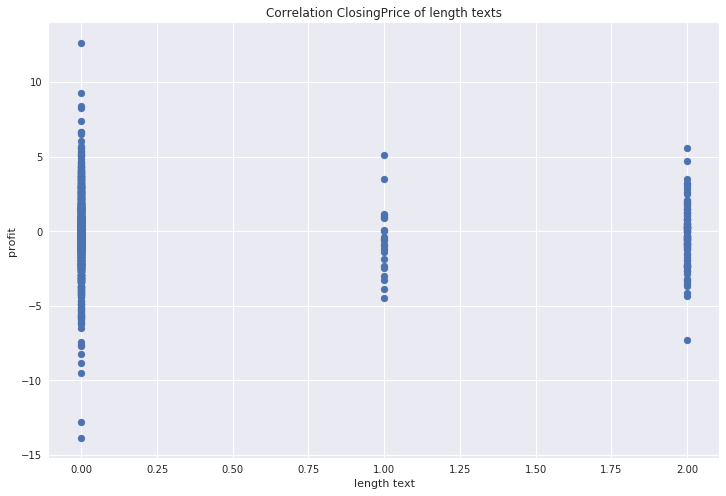

In [32]:
plt.figure(figsize=(12, 8))
plt.scatter(result.count_miller, result.profit)
plt.title('Correlation ClosingPrice of length texts')
plt.xlabel('length text')
plt.ylabel('profit')
plt.show();

In [33]:
pearsonr(result.count_miller, result.profit)

(-0.024324060934246324, 0.41090814095972605)

In [34]:
pearsonr(result.count_miller, result.ClosingPrice)

(0.0014898134838023938, 0.95983786333755017)

__Корреляции нет между именем и ценой закрытия.__

### Упоминаний какого газопровода в статьях больше: 
* "северный поток"
* "турецкий поток"?

In [35]:
sever = 0 
tur = 0
for idx, text in enumerate(list(result.text)):
    if 'северный' in text and 'поток' in text:
        sever += 1
    if 'север' in text and 'поток' in text:
        sever += 1 
    if 'турецкий' in text and 'поток' in text:
        tur += 1
    if 'турция' in text and 'поток' in text:
        tur += 1        
print (sever)
print (tur)

32
53


__Ответ: турецкий поток упоминается чаще.__

### О каких санкциях пишут в статьях?

In [36]:
texts = []
for i in range(len(result)):
    tokens = result.text.iloc[i].split()
    texts.append(tokens)

In [37]:
morph = pymorphy2.MorphAnalyzer()

In [38]:
sanctions = []
for text in texts:
    for idx, word in enumerate(text):
        if word == 'санкция':
            if idx > 0:
                if text[idx-1] not in sanctions and morph.parse(text[idx-1])[0].tag.POS == 'ADJF':
                    sanctions.append(text[idx-1])

In [39]:
sanctions

['американский',
 'западный',
 'очередной',
 'экономический',
 'антироссийский',
 'персональный',
 'штрафной',
 'секторальный',
 'финансовый',
 'международный']

## Часть 2. Классификационная
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случае;
* составьте обучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

In [40]:
pr_all.head(2)

,date,open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,08.12.2017,133.43,132.60,133.90,132.00,16037970
1,07.12.2017,133.70,133.02,133.87,132.81,18198430


In [41]:
pr_all['ClosingPricePrevios'] = np.array(pr_all['ClosingPrice'].append(pd.Series([0]))[1:])
pr_all['ClosingPrice_diff'] = pr_all['ClosingPrice'] - pr_all['ClosingPricePrevios'] 

In [42]:
pr_all['ClosingPrice_bin'] = np.where(pr_all['ClosingPrice_diff'] >= 0, 1, 0)

In [43]:
pr_all.head(3)

,date,open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,ClosingPricePrevios,ClosingPrice_diff,ClosingPrice_bin
0,08.12.2017,133.43,132.60,133.90,132.00,16037970,133.02,-0.42,0
1,07.12.2017,133.70,133.02,133.87,132.81,18198430,134.00,-0.98,0
2,06.12.2017,133.33,134.00,134.29,132.91,14641730,133.65,0.35,1


In [44]:
data = pd.merge(result[['date', 'text']], pr_all[['date', 'ClosingPrice_bin']] , how='inner', on='date')

In [45]:
data.head(3)

,date,text,ClosingPrice_bin
0,09.11.2017,компания рассчитывать решение газовый спор укр...,0
1,08.11.2017,предполагать ъ газпром воспользоваться жалоба ...,1
2,01.11.2017,новый редакция американский санкция ставить уг...,1


In [46]:
data.date = pd.to_datetime(data.date)

In [47]:
X_train = data[data.date <'2017-01-01']
y_train = X_train.ClosingPrice_bin

In [48]:
X_train.head(3)

,date,text,ClosingPrice_bin
104,2016-12-29,расход газпром-медиа год расти быстро доход из...,1
105,2016-12-28,данный ъ ростеха последний год активно развива...,1
106,2016-12-27,роснефть опережать консорциум газпром нефть га...,1


In [49]:
X_train.head(3)

,date,text,ClosingPrice_bin
104,2016-12-29,расход газпром-медиа год расти быстро доход из...,1
105,2016-12-28,данный ъ ростеха последний год активно развива...,1
106,2016-12-27,роснефть опережать консорциум газпром нефть га...,1


In [50]:
len(y_train), len(X_train)

(1041, 1041)

In [51]:
X_test = data[data.date >= '2017-01-01']
y_test = X_test.ClosingPrice_bin

In [52]:
X_test.head(3)

,date,text,ClosingPrice_bin
0,2017-09-11,компания рассчитывать решение газовый спор укр...,0
1,2017-08-11,предполагать ъ газпром воспользоваться жалоба ...,1
2,2017-01-11,новый редакция американский санкция ставить уг...,1


In [53]:
len(X_train), len(X_test)

(1041, 104)

### RandomForestClassifier с использованием Pipeline

In [54]:
clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('reducer', TruncatedSVD()),
    ('clf', RandomForestClassifier()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'tfidf__norm': ('l1', 'l2'),
    'reducer__n_components': (2, 10, 100), 
    'clf__max_depth' : (None, 10),
}

In [55]:
grid_search = GridSearchCV(clf, parameters, n_jobs=-1, verbose=1)

In [56]:
grid_search.fit(X_train.text, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   29.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'tfidf__norm': ('l1', 'l2'), 'reducer__n_components': (2, 10, 100), 'clf__max_depth': (None, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [57]:
pred = grid_search.predict(X_test.text)

In [58]:
def report_metrics(y_test, y_pred, clf):
    print("Precision: {0:6.2f}".format(precision_score(y_test, y_pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(y_test, y_pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(y_test, y_pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred))
    labels = clf.classes_
    sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix")
    plt.show()

Precision:   0.56
Recall:   0.56
F1-measure:   0.56
Accuracy:   0.56
             precision    recall  f1-score   support

          0       0.62      0.56      0.59        59
          1       0.49      0.56      0.52        45

avg / total       0.57      0.56      0.56       104



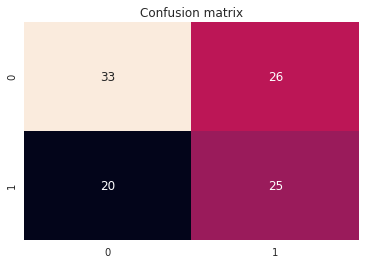

In [59]:
report_metrics(y_test, pred, grid_search)

### BernoulliNB

In [60]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB()),
])
parameters = {
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2)),  # unigrams or bigrams
    'clf__alpha': (0.1, 0.5, 1.0, 5.0),
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

In [61]:
grid_search.fit(X_train.text, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    7.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...se, use_idf=True)), ('clf', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__ngram_range': ((1, 1), (1, 2), (2, 2)), 'clf__alpha': (0.1, 0.5, 1.0, 5.0)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [62]:
pred = grid_search.predict(X_test.text)

Precision:   0.56
Recall:   0.56
F1-measure:   0.56
Accuracy:   0.56
             precision    recall  f1-score   support

          0       0.63      0.53      0.57        59
          1       0.49      0.60      0.54        45

avg / total       0.57      0.56      0.56       104



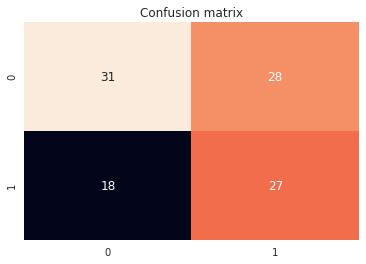

In [63]:
report_metrics(y_test, pred, grid_search)

## Часть 3. Творческая
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по эмбеддингам глаголов (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     

### Оставим только существительные

In [64]:
vocab[:5]

['аа', 'аббас', 'абдул', 'абк', 'абонент']

In [65]:
not_noun_list = []
for word in vocab:
    if morph.parse(word)[0].tag.POS != 'NOUN':
        not_noun_list.append(word)

In [66]:
not_noun_list[:5]

['аа', 'абк', 'абонентский', 'абсолютно', 'абсолютный']

In [67]:
def remove_not_noun(text, not_nouns=not_noun_list):
    try:
        return " ".join([token for token in text.split() if not token in not_nouns])
    except:
        return ""

In [68]:
X_test.text = X_test.text.apply(remove_not_noun)
X_train.text = X_train.text.apply(remove_not_noun)

/home/seradja/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


#### Запустим на новых данных наши классификаторы, которые мы уже использовали

In [69]:
clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('reducer', TruncatedSVD()),
    ('clf', RandomForestClassifier()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'tfidf__norm': ('l1', 'l2'),
    'reducer__n_components': (2, 10, 100), 
    'clf__max_depth' : (None, 10),
}

grid_search = GridSearchCV(clf, parameters, n_jobs=-1, verbose=1)

In [70]:
grid_search.fit(X_train.text, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   17.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'tfidf__norm': ('l1', 'l2'), 'reducer__n_components': (2, 10, 100), 'clf__max_depth': (None, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [71]:
pred = grid_search.predict(X_test.text)

Precision:   0.58
Recall:   0.58
F1-measure:   0.57
Accuracy:   0.57
             precision    recall  f1-score   support

          0       0.65      0.51      0.57        59
          1       0.50      0.64      0.56        45

avg / total       0.59      0.57      0.57       104



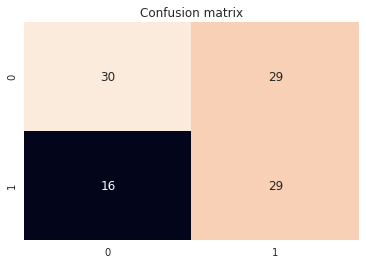

In [72]:
report_metrics(y_test, pred, grid_search)

### Оставив только существительные - мы не смогли добиться существенного роста.

### CatBoostClassifier

In [73]:
clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('reducer', TruncatedSVD(n_components=10)),
    ('clf', CatBoostClassifier()),
])

parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'tfidf__norm': ('l1', 'l2'),
    #'reducer__n_components': (10), 
    #'clf__depth' : (2, 6, 15),
}

grid_search = GridSearchCV(clf, parameters, n_jobs=-1, verbose=1)

In [74]:
grid_search.fit(X_train.text, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip... random_state=None, tol=0.0)), ('clf', <catboost.core.CatBoostClassifier object at 0x7f53d89b4ef0>)]),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [75]:
pred = grid_search.predict(X_test.text)

Precision:   0.51
Recall:   0.51
F1-measure:   0.51
Accuracy:   0.51
             precision    recall  f1-score   support

          0       0.57      0.53      0.55        59
          1       0.44      0.49      0.46        45

avg / total       0.52      0.51      0.51       104



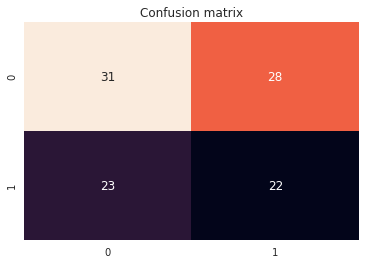

In [76]:
report_metrics(y_test, pred, grid_search)

### LSI

In [77]:
dictionary = corpora.Dictionary(texts)
print(dictionary)

Dictionary(6734 unique tokens: ['компания', 'рассчитывать', 'решение', 'газовый', 'спор']...)


In [79]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [80]:
lsimodel = LsiModel(corpus=corpus, num_topics=2, id2word=dictionary)

In [81]:
lsimodel.show_topics()

[(0,
  '0.705*"газпром" + 0.291*"компания" + 0.255*"газ" + 0.219*"нефть" + 0.140*"который" + 0.135*"год" + 0.130*"сообщать" + 0.121*"российский" + 0.096*"цена" + 0.088*"поставка"'),
 (1,
  '-0.569*"нефть" + 0.565*"газ" + -0.276*"компания" + 0.185*"украина" + 0.179*"поставка" + -0.096*"месторождение" + 0.093*"европа" + 0.093*"российский" + 0.084*"газопровод" + 0.083*"кубометр"')]